# U-Net Brain Tumor Segmentation

In [33]:
import tensorflow as tf
import keras
from keras.callbacks import Callback
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard

import numpy as np
import os
import SimpleITK as sitka
import random
import matplotlib.pyplot as plt
import importlib
import time

# Data augmentation
import cv2
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, ElasticTransform, Rotate, RandomScale, GridDistortion, OpticalDistortion, OneOf
)

# Custom scripts
import datagen
import model as unet_model_script

# Reload lib contents
importlib.reload(datagen)
importlib.reload(unet_model_script)

<module 'model' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\model.py'>

##  Hyperparemeters

In [47]:
train_HGG_patients = 239
valid_HGG_patients = 20
slices_from_patient = 15

image_size = 240
channels = 4
learning_rate = 1e-4
epochs = 25
batch_size = 7


### U-Net model parameters

Configuration dict.

In [48]:
conf = {
    "last_layer_activation": "sigmoid",
    "dropout": 0.05,
    "batch_norm": True
}

In [49]:
training_model_conf = {
    "optimizer": keras.optimizers.Adam(learning_rate=learning_rate),
    "loss": "binary_crossentropy",
    "metrics": ["accuracy"]
}

## Dataset

In [21]:
x_train, y_train = datagen.get_dataset(slices_from_patient, 
                                        file_path='../dataset/', 
                                        mode='training', 
                                        glioma_type=['HGG'], 
                                        slices_w_tumor_only=100,
                                        slices_w_less_brain=None,
                                        image_size=image_size,
                                        train_HGG_patients=train_HGG_patients)

training data with shape: (3585, 4, 240, 240) (3585, 1, 240, 240)


In [22]:
x_valid, y_valid = datagen.get_dataset(slices_from_patient, 
                                        file_path='../dataset/', 
                                        mode='validation', 
                                        glioma_type=['HGG'], 
                                        slices_w_tumor_only=False,
                                        slices_w_less_brain=None,
                                        image_size=240,
                                        train_HGG_patients=valid_HGG_patients)

validation data with shape: (300, 4, 240, 240) (300, 1, 240, 240)


## Model (U-Net)

In [50]:
model = unet_model_script.UNet(channels, image_size, conf=conf)
model.compile(**training_model_conf)

## Data augmentation

In [51]:
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
#     Rotate(limit=90, p=0.99),
#     RandomGamma(gamma_limit=(80, 120), p=0.25),
#     RandomScale(scale_limit=0.1, interpolation=cv2.INTER_NEAREST, p=0.25),
#     ElasticTransform(alpha=1, p=0.5),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#     ], p=0.2),
    OpticalDistortion(p=0.5),
    GridDistortion(p=0.5),
])

In [52]:
train_gen = datagen.AugmentationDatagen(x_train, y_train, batch_size, AUGMENTATIONS)

## Callbacks

In [53]:
class NegativeLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        if logs.get('loss') < 0:
            print("\nEarly stopping for negative loss ({}) at batch {}.".format(logs.get('loss'), batch))
            self.model.stop_training = True

callbacks = [
    NegativeLoss(),
    keras.callbacks.callbacks.TerminateOnNaN(),
    keras.callbacks.callbacks.EarlyStopping(monitor='accuracy', 
                                            min_delta=0.0001, 
                                            patience=10, 
                                            verbose=1, 
                                            mode='auto', 
                                            baseline=None, 
                                            restore_best_weights=True),
    keras.callbacks.callbacks.ReduceLROnPlateau(factor=0.1, 
                                                patience=5, 
                                                min_lr=0.00001, 
                                                verbose=1),
#     keras.callbacks.TensorBoard(log_dir="../logs/{}".format(time.time()))
]

# Ensemble training

In [ ]:
models = {}
for tumor_region in range(1, 5):
    

In [54]:
hist = model.fit(train_gen, validation_data=(x_valid, y_valid), epochs=epochs, shuffle=True, callbacks=callbacks)

Epoch 1/25
 18/513 [>.............................] - ETA: 6:44 - loss: 0.3788 - accuracy: 0.8191
Early stopping for negative loss (-0.17329351603984833) at batch 17.


C:\Users\krcma\.conda\envs\tfgpu\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


### Results

KeyError: 'val_accuracy'

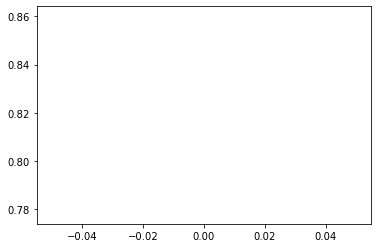

In [55]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(x_valid, verbose=1)

In [ ]:
pred.shape

In [ ]:
i = random.randint(0, 238)
# i = 0
f, axarr = plt.subplots(1,4, figsize=(10,10))
axarr[0].imshow(x_valid[i][0]) #, cmap='gray', vmin=0
axarr[0].imshow(y_valid[i][0], alpha=0.5) #, cmap='gray', vmin=0
axarr[1].imshow(x_valid[i][0]) #, cmap='gray', vmin=0
axarr[1].imshow(pred[i][0], alpha=0.5) #, cmap='gray', vmin=0
axarr[2].imshow(y_valid[i][0], alpha=1) #, cmap='gray', vmin=0
axarr[3].imshow(pred[i][0], alpha=1) #, cmap='gray', vmin=0

In [ ]:
model.save("../models/unet_{}.h5".format("one_to_label_them_all"))